In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [2]:
INPUT_SIZE = 3 # thickness, height, angle
LEARNING_RATE = 0.001
BATCH_SIZE = 32 # 
NUM_EPOCHS = 1000

TEST_SIZE = 0.2
RANDOM_STATE = 42
device = "cpu"

In [3]:
df = pd.read_csv(r'../processed_bending_stiffness.csv')

# Remove duplicates
initial_count = len(df)
df = df.drop_duplicates()
removed_count = initial_count - len(df)
if removed_count > 0:
    print(f"Removed {removed_count} duplicate row(s) from the dataset.")
print(f"Shape of dataset after removing duplicates: {df.shape}")

X = df[['Thickness', 'Height', 'Angle (deg)']]
y = df['Bending_Stiffness']

# First split: separate out test set
X_temp, X_test, y_temp, y_test = train_test_split(
    X.values, 
    y.values, 
    test_size=TEST_SIZE,  # 0.2 = 20% for test
    random_state=RANDOM_STATE
)

# Second split: split remaining data into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=0.25,  # 0.25 * 0.8 = 0.2 of total (so 60% train, 20% val, 20% test)
    random_state=RANDOM_STATE
)

print(f"\nDataset Split:")
print(f"Train set size: {len(X_train)} ({len(X_train)/len(df)*100:.1f}%)")
print(f"Validation set size: {len(X_val)} ({len(X_val)/len(df)*100:.1f}%)")
print(f"Test set size: {len(X_test)} ({len(X_test)/len(df)*100:.1f}%)")

DATASET_SIZE = len(df)

Removed 685 duplicate row(s) from the dataset.
Shape of dataset after removing duplicates: (891, 4)

Dataset Split:
Train set size: 534 (59.9%)
Validation set size: 178 (20.0%)
Test set size: 179 (20.1%)


In [13]:
model = nn.Sequential(
        nn.Linear(INPUT_SIZE, 64),
        nn.ReLU(),
        nn.Dropout(p=0.2),
        
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Dropout(p=0.2),

        nn.Linear(32, 16),
        nn.ReLU(),
        nn.Dropout(p=0.2),
        
        # Output Layer
        nn.Linear(16, 1)
).to(device)

In [ ]:
# Convert TRAINING
X_train_tensor = torch.from_numpy(X_train.astype(np.float32))
y_train_tensor = torch.from_numpy(y_train.astype(np.float32)).unsqueeze(1)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Convert VALIDATION
X_val_tensor = torch.from_numpy(X_val.astype(np.float32))
y_val_tensor = torch.from_numpy(y_val.astype(np.float32)).unsqueeze(1)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Convert TESTING
X_test_tensor = torch.from_numpy(X_test.astype(np.float32))
y_test_tensor = torch.from_numpy(y_test.astype(np.float32)).unsqueeze(1)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


--- Starting Training ---
Epoch [1/1000], Train Loss (t_loss): 87715133.0337, Val Loss (v_loss): 98430833.2067
Epoch [2/1000], Train Loss (t_loss): 87203795.9551, Val Loss (v_loss): 97375423.5084
Epoch [3/1000], Train Loss (t_loss): 85319643.7753, Val Loss (v_loss): 93512627.1285
Epoch [4/1000], Train Loss (t_loss): 79506608.9888, Val Loss (v_loss): 83364031.5978
Epoch [5/1000], Train Loss (t_loss): 66368702.2921, Val Loss (v_loss): 63149805.0056
Epoch [6/1000], Train Loss (t_loss): 45233189.6742, Val Loss (v_loss): 37348634.7933
Epoch [7/1000], Train Loss (t_loss): 27713474.2472, Val Loss (v_loss): 23997382.2793
Epoch [8/1000], Train Loss (t_loss): 25150211.3258, Val Loss (v_loss): 22809694.7933
Epoch [9/1000], Train Loss (t_loss): 25246190.4719, Val Loss (v_loss): 22878247.8436
Epoch [10/1000], Train Loss (t_loss): 23332046.6966, Val Loss (v_loss): 22150902.9050
Epoch [11/1000], Train Loss (t_loss): 25137180.3146, Val Loss (v_loss): 22066856.2011
Epoch [12/1000], Train Loss (t_loss)

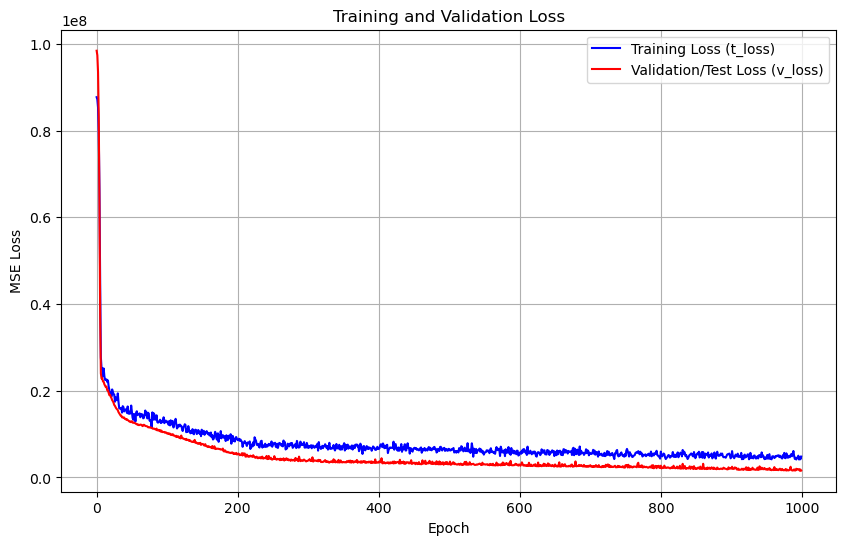


--- Final Evaluation on Test Set ---

Test Set Metrics:
MSE: 1589494.8464
RMSE: 1260.7517
MAE: 816.0933
R-squared (R²): 0.9634

Training and Evaluation complete.


In [ ]:
mae_criterion = nn.L1Loss()  # Mean Absolute Error Loss
criterion = nn.MSELoss()  # Mean Squared Error Loss

trainLoss = []
validationLoss = []
print("\n--- Starting Training ---")
for epoch in range(NUM_EPOCHS):
    model.train()  # Set model to training mode
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * targets.size(0)
    
    avg_train_loss = running_loss / len(X_train)
    trainLoss.append(avg_train_loss) # Store the average training loss
    model.eval()
    running_val_loss = 0.0
    val_samples = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            outputs = model(inputs)
            val_loss = criterion(outputs, targets) # Use the same loss for comparison
            running_val_loss += val_loss.item() * targets.size(0)
            val_samples += targets.size(0)
    
    avg_val_loss = running_val_loss / val_samples
    validationLoss.append(avg_val_loss) # Store the average validation loss
    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss (t_loss): {avg_train_loss:.4f}, Val Loss (v_loss): {avg_val_loss:.4f}')

plt.figure(figsize=(10, 6))
plt.plot(trainLoss, label='Training Loss (t_loss)', color='blue')
plt.plot(validationLoss, label='Validation/Test Loss (v_loss)', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show() #

# --- Final Evaluation on TEST SET ---
print("\n--- Final Evaluation on Test Set ---")
model.eval()
total_squared_error = 0.0
total_absolute_error = 0.0
total_samples = 0
all_targets = []
all_predictions = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        outputs = model(inputs)
        
        # MSE loss
        mse_loss = criterion(outputs, targets)
        total_squared_error += mse_loss.item() * targets.size(0)
        
        # MAE loss
        mae_loss = mae_criterion(outputs, targets)
        total_absolute_error += mae_loss.item() * targets.size(0)
        
        total_samples += targets.size(0)
        all_targets.append(targets.cpu())
        all_predictions.append(outputs.cpu())

# Concatenate all targets and predictions
targets_tensor = torch.cat(all_targets)
predictions_tensor = torch.cat(all_predictions)

# Calculate metrics
mean_squared_error = total_squared_error / total_samples
root_mean_squared_error = np.sqrt(mean_squared_error)
mean_absolute_error = total_absolute_error / total_samples

# R-squared
ss_residual = total_squared_error
target_mean = targets_tensor.mean()
ss_total = ((targets_tensor - target_mean) ** 2).sum().item()
r_squared = 1 - (ss_residual / ss_total) if ss_total != 0 else 0.0

print(f'\nTest Set Metrics:')
print(f'MSE: {mean_squared_error:.4f}')
print(f'RMSE: {root_mean_squared_error:.4f}')
print(f'MAE: {mean_absolute_error:.4f}')
print(f'R-squared (R²): {r_squared:.4f}')
print("\nTraining and Evaluation complete.")

In [16]:
torch.save(model.state_dict(), 'model_weight.pth')

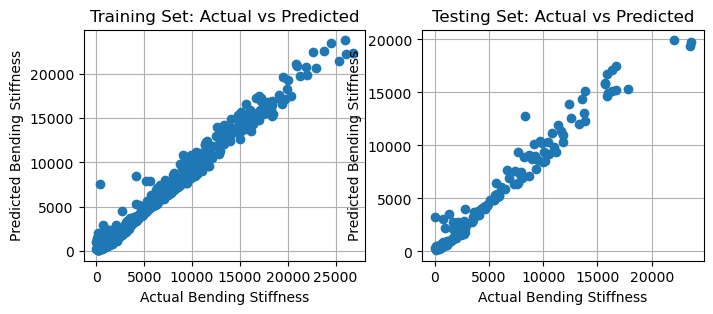

In [ ]:
# Training set predictions
array_y_train_pred = model(X_train_tensor).detach().numpy()
array_y_train = y_train_tensor.detach().numpy()

# Validation set predictions
array_y_val_pred = model(X_val_tensor).detach().numpy()
array_y_val = y_val_tensor.detach().numpy()

# Test set predictions
array_y_test_pred = model(X_test_tensor).detach().numpy()
array_y_test = y_test_tensor.detach().numpy()

pyplot.figure(figsize=(15, 4))

pyplot.subplot(1, 3, 1)
pyplot.plot(array_y_train, array_y_train_pred, 'o', alpha=0.6)
pyplot.plot([array_y_train.min(), array_y_train.max()], 
            [array_y_train.min(), array_y_train.max()], 
            'r--', linewidth=2)
pyplot.xlabel('Actual Bending Stiffness')
pyplot.ylabel('Predicted Bending Stiffness')
pyplot.title('Training Set: Actual vs Predicted')
pyplot.grid("on")

pyplot.subplot(1, 3, 2)
pyplot.plot(array_y_val, array_y_val_pred, 'o', alpha=0.6, color='orange')
pyplot.plot([array_y_val.min(), array_y_val.max()], 
            [array_y_val.min(), array_y_val.max()], 
            'r--', linewidth=2)
pyplot.xlabel('Actual Bending Stiffness')
pyplot.ylabel('Predicted Bending Stiffness')
pyplot.title('Validation Set: Actual vs Predicted')
pyplot.grid("on")

pyplot.subplot(1, 3, 3)
pyplot.plot(array_y_test, array_y_test_pred, 'o', alpha=0.6, color='green')
pyplot.plot([array_y_test.min(), array_y_test.max()], 
            [array_y_test.min(), array_y_test.max()], 
            'r--', linewidth=2)
pyplot.xlabel('Actual Bending Stiffness')
pyplot.ylabel('Predicted Bending Stiffness')
pyplot.title('Testing Set: Actual vs Predicted')
pyplot.grid("on")

pyplot.tight_layout()
pyplot.show()

In [16]:
print(model(torch.tensor([[4.91, 33.80, 47.35]], dtype=torch.float32)))  # Example bending stiffness input

tensor([[680.5567]], grad_fn=<AddmmBackward0>)
